## Overview - Best Next Action

Banks make a margin on every credit card transaction that is made by their customers. So they want their customers to spend more on their credit cards. In order to increase credit card spending, the bank sends marketing messages to their customers to encourage those customers to use their credit cards more. These messages may be sent via email, mail or SMS. The messages may be retail discount offers, holiday destinations or gift ideas.

But with a large pool of customers and range of communication channels and messages, how does the bank know who to target with which channel and which message? Traditionally, marketers apply customer segmentation across the entire customer database. However, every customer is unique. Some organizations send the same messages to all customers or to all customers in a segment, but this might be seen as annoying SPAM and push customers away.

The solution is to develop a targeted Next Best Action for each individual customer, which is which channel and message to send next to each individual. Sometimes the next best action is to send nothing.

## Classification Problems In DataRobot

The problem described above is a classification problem.  In DataRobot, we characterize classifications problem in 1 of 3 ways. 

1.  Binary Classification: 2 classes

2.  Multiclass: 3-10 classes

3.  Extended Multiclass: 11 to 100 classes.  

In [391]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import colors
from scipy import interp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [392]:
from config import *
import datarobot as dr
dr.Client(token=DATAROBOT_API_TOKEN, endpoint=DATAROBOT_ENDPOINT)

In [393]:
data_dict

,Special Column?,Description
Feature,,
age,NaN,age of the customer
marital,NaN,marital status of the customer
income,NaN,annual income of the customer
creditRating,NaN,customer's credit rating
aveSpend,NaN,customer's average credit card spend per month
touchpoints,NaN,list of marketing touchpoints this customer ha...
nTouchpoints,NaN,number of marketing touchpoints this customer ...
action,TARGET,which marketing touchpoint to send to the cust...


In [394]:
data_dict = pd.read_excel("DR_Demo_Next_Best_Action_Data_Dictionary.xlsx")
data_dict.set_index("Feature", inplace=True)
print("Fields in the data set")
for idx in data_dict.index:
    print(idx,":", data_dict.loc[idx]["Description"])

Fields in the data set
age : age of the customer
marital : marital status of the customer
income : annual income of the customer
creditRating : customer's credit rating
aveSpend : customer's average credit card spend per month
touchpoints : list of marketing touchpoints this customer has experienced during the data period
nTouchpoints : number of marketing touchpoints this customer has experienced during the data period
action : which marketing touchpoint to send to the customer next


In [395]:
## read in dataa
df = pd.read_csv("DR_Demo_Next_Best_Action.csv")

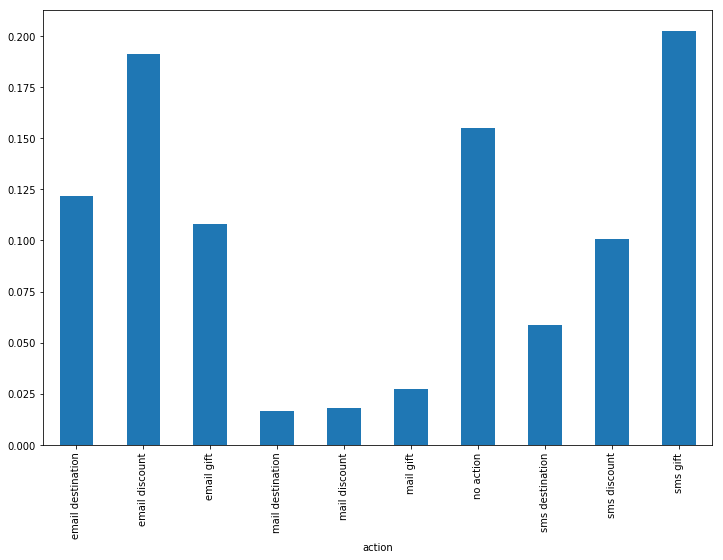

In [396]:
# frequency plot of target variable 
fig, ax = plt.subplots(1,1,figsize=[12,8])
freq= pd.crosstab(index=df["action"],columns="count")
(freq / freq.sum()).plot(kind="bar", legend=False, ax=ax)

In [328]:
print(freq)

col_0              count
action                  
email destination   2432
email discount      3820
email gift          2163
mail destination     332
mail discount        362
mail gift            551
no action           3100
sms destination     1175
sms discount        2014
sms gift            4051


## What kind of classification?

This is a multiclass problem as there are 10 unique classes.  In DataRobot there are two ways in which we can handle this problem.  

1.  Multiclass Classification
2.  One Vs. All Classification

In [211]:
## kick of our multiclass project

mcp = dr.Project.create(df, project_name = "multiclass")
mcp.set_target(target="action",mode="manual")
blueprints = mcp.get_blueprints()
## for simplicity, we'll run one xgboost model (instead of full autopilot)
model = list(filter(lambda x: "eXtreme" in str(x), blueprints)).pop(0)
mcp.train(model, sample_pct=64)
mcp_model = mcp.get_models()[0]

'5'

In [224]:
mcp_model = mcp.get_models()[0]

## One Vs All

In [19]:
classes = df["action"].unique()

array(['email discount', 'sms gift', 'sms discount', 'sms destination',
       'email destination', 'no action', 'email gift', 'mail gift',
       'mail destination', 'mail discount'], dtype=object)

In [50]:
def one_vs_all_mf(multiclass_column_name, data):
    ## create a project per class for a one vs all type problem
    ## train an xgboost per project
    project_list = []
    classes = data[multiclass_column_name].unique()
    for c in classes:
        df["target"] = df[multiclass_column_name].apply(lambda x: x == c)
        p = dr.Project.create(df.drop([multiclass_column_name],axis=1), project_name = c)
        p.set_target("target", mode="manual")
        blueprints = p.get_blueprints()
        model = list(filter(lambda x: "eXtreme" in str(x), blueprints)).pop(0)
        p.train(model, sample_pct=64)
        project_list.append(p)
    return project_list

In [51]:
projects = one_vs_all_mf("action", df)

In [ ]:
# df["partition"] # i would set this

# dr.AdvancedOptions()

In [447]:
projects

[Project(email discount),
 Project(sms gift),
 Project(sms discount),
 Project(sms destination),
 Project(email destination),
 Project(no action),
 Project(email gift),
 Project(mail gift),
 Project(mail destination),
 Project(mail discount)]

In [59]:
models = [p.get_models()[0] for p in projects]

# A one vs all ROC and AUC

In [135]:
roc_curves = {}
for m in models:
    roc_points = m.get_all_roc_curves()[0].roc_points
    points = [(x["false_positive_rate"],x["true_positive_rate"]) for x in roc_points]
    fpr, tpr = zip(*points)
    roc_curves["{} - AUC: {:.3}".format(str(m.project), m.metrics["AUC"]["validation"])] = {"tpr":tpr, "fpr":fpr}


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataRobotDeprecationWarning: `project` has been deprecated in `v2.3`, will be removed in `v3.0`. Use Model.project_id instead
  


In [293]:
## average out the roc curves
## taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

n_classes = len(classes)

all_fpr = np.unique(np.concatenate([y["fpr"] for x,y in roc_curves.items()]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)

for x,y in roc_curves.items():
    mean_tpr += interp(all_fpr, y["fpr"], y["tpr"]) 

# Finally average it and compute AUC
mean_tpr /= n_classes # freq.sum().values[0] #n_classes

from sklearn.metrics import roc_curve, auc
fpr_macro = all_fpr
tpr_macro = mean_tpr
auc_macro = auc(fpr_macro, tpr_macro)

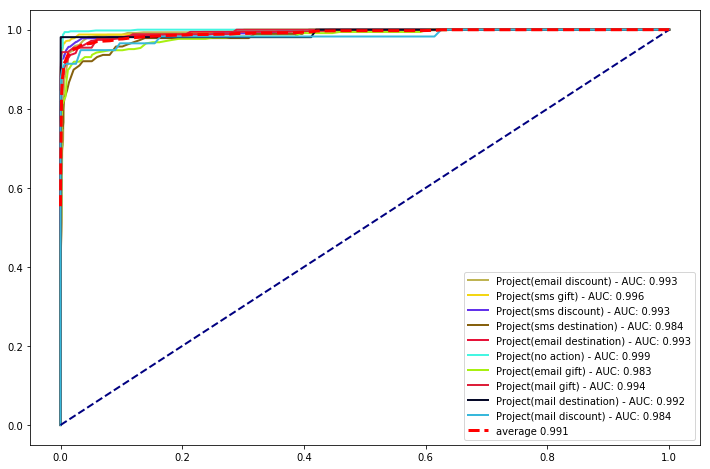

In [432]:
np.random.seed(138)
plt.figure(figsize=[12,8])
lw=2
for x,y in roc_curves.items():
    plt.plot(y["fpr"],y["tpr"], c = np.random.rand(3,), lw=lw, label = str(x))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr_macro, tpr_macro, color="red", lw=3, linestyle="--",label = "average {:.3}".format(auc_macro))
plt.legend(loc="lower right");

In [342]:
[m.request_feature_impact() for m in models]
## make a table of normalized feature impacts 
## columns will be features rows will be project.  
#mcp_fi = pd.DataFrame(mcp_model.get_or_request_feature_impact()).set_index("featureName")["impactNormalized"]
projects_fi = [pd.DataFrame(m.get_feature_impact()).set_index("featureName")["impactNormalized"] for m in models]
#projects_fi.append(mcp_fi)
fi_columns = [str(m.project) for m in models]
#fi_columns.append("mcp")
fi = pd.concat([p.T for p in projects_fi],sort=True,axis=1)
fi.columns = fi_columns
fi.T

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataRobotDeprecationWarning: `project` has been deprecated in `v2.3`, will be removed in `v3.0`. Use Model.project_id instead
  """


,age,aveSpend,creditRating,income,marital,nTouchpoints,touchpoints
Project(email discount),0.560065,0.445480,0.082126,0.501364,0.110289,0.248386,1.000000
Project(sms gift),0.150182,0.096783,0.026667,0.143953,0.074607,0.082838,1.000000
Project(sms discount),0.126618,0.134826,0.039019,0.132522,0.051054,0.076273,1.000000
Project(sms destination),1.000000,0.645773,0.197698,0.785179,0.103930,0.497621,0.692883
Project(email destination),0.202693,0.323884,0.058946,0.348002,0.120995,0.139804,1.000000
Project(no action),0.092821,0.154674,0.036277,0.084925,0.025760,1.000000,0.535693
Project(email gift),0.706552,0.576108,0.141443,0.545094,0.127748,0.283187,1.000000
Project(mail gift),0.506428,0.509347,0.268505,0.503160,0.109489,0.388790,1.000000
Project(mail destination),0.508408,0.603282,0.212436,0.661349,0.100574,0.576074,1.000000
Project(mail discount),0.418319,0.499071,0.098852,0.317490,0.039882,0.300177,1.000000


In [339]:
fi_sorted = np.argsort(fi.T, axis=1)
for c in fi_sorted.columns:
    fi_sorted[c] = fi_sorted[c].apply(lambda x: fi_sorted.columns[x])    
fi_sorted.columns = [ "feature {}".format(i) for i in np.arange(fi_sorted.shape[1])]

In [354]:
fi_sorted

,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6
Project(email discount),creditRating,marital,nTouchpoints,aveSpend,income,age,touchpoints
Project(sms gift),creditRating,marital,nTouchpoints,aveSpend,income,age,touchpoints
Project(sms discount),creditRating,marital,nTouchpoints,age,income,aveSpend,touchpoints
Project(sms destination),marital,creditRating,nTouchpoints,aveSpend,touchpoints,income,age
Project(email destination),creditRating,marital,nTouchpoints,age,aveSpend,income,touchpoints
Project(no action),marital,creditRating,income,age,aveSpend,touchpoints,nTouchpoints
Project(email gift),marital,creditRating,nTouchpoints,income,aveSpend,age,touchpoints
Project(mail gift),marital,creditRating,nTouchpoints,income,age,aveSpend,touchpoints
Project(mail destination),marital,creditRating,age,nTouchpoints,aveSpend,income,touchpoints
Project(mail discount),marital,creditRating,nTouchpoints,income,age,aveSpend,touchpoints


## Feature Impact for the Multiclass XGBoost

Text(0.5, 1.04, 'Feature Impact')

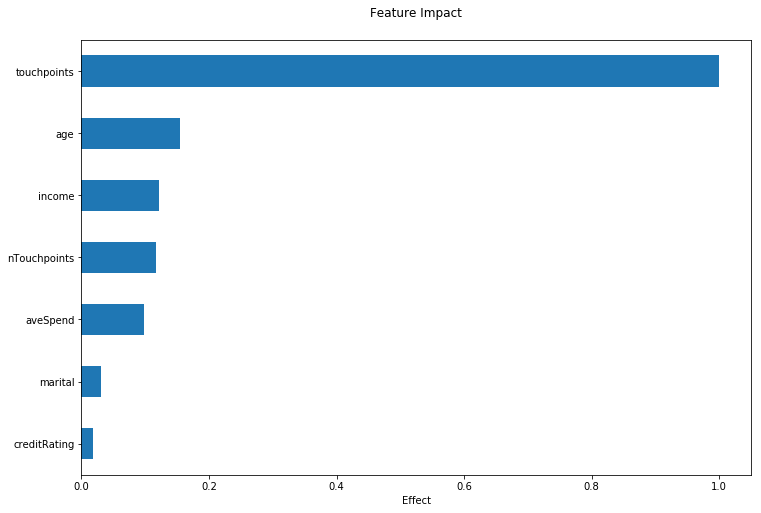

In [446]:
mcp_fi = pd.DataFrame(mcp_model.get_or_request_feature_impact())

# Formats the ticks from a float into a percent
percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

dr_dark_blue = '#08233F'
dr_blue = '#1F77B4'
dr_orange = '#FF7F0E'
dr_red = '#BE3C28'

mcp_fi.sort_values(by='impactNormalized', ascending=True, inplace=True)

# Positive values are blue, negative are red
bar_colors = mcp_fi.impactNormalized.apply(lambda x: dr_red if x < 0
                                              else dr_blue)

ax = mcp_fi.plot.barh(x='featureName', y='impactNormalized',
                         legend=False,
                         color=bar_colors,
                         figsize=(12, 8))

plt.ylabel('')
plt.xlabel('Effect')
# plt.xlim((None, 1))  # Allow for negative impact
plt.title('Feature Impact', y=1.04)

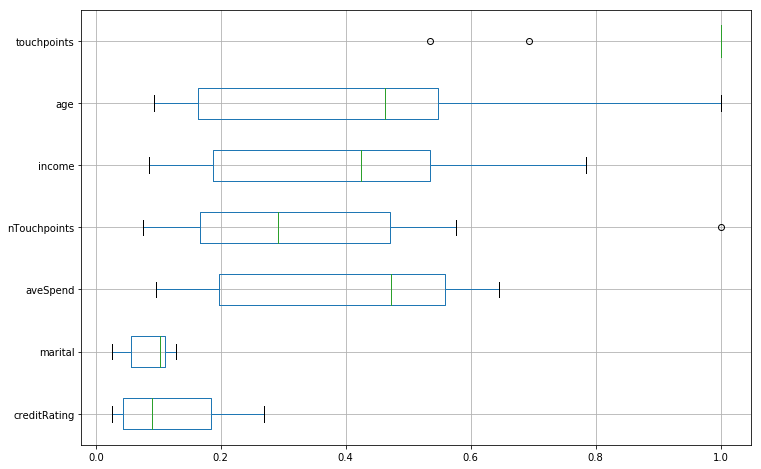

In [375]:
fig, ax = plt.subplots(1,1,figsize = [12,8])
fi.T[mcp_fi["featureName"].values].boxplot(ax=ax, vert=False)

## Converting One vs All Probs to multiclass probs.  

If you already have probabilities, you can simply do `probs/probs.sum(axis=1, keepdims=True)`, which will normalize the probabilities for each row such that they sum to one.  

A clever way to make class assignments for multiclass problems.  https://stats.stackexchange.com/questions/208915/one-vs-many-one-vs-all-what-value-to-use-as-probability

In [407]:
datasets = [p.upload_dataset(df) for p in projects]

In [410]:
preds_request = [(str(m.project), m.request_predictions(d.id)) for m, d in zip(models, datasets)]

In [413]:
pred_results = [p.get_result_when_complete() for p in preds_request]

In [425]:
preds_results_df = pd.DataFrame([p["positive_probability"] for p in pred_results]).T
preds_results_df.columns = [str(p) for p in projects]

In [429]:
norm_preds_results_df = preds_results_df / preds_results_df.values.sum(axis=1, keepdims=True)

In [431]:
norm_preds_results_df.head()

,Project(email discount),Project(sms gift),Project(sms discount),Project(sms destination),Project(email destination),Project(no action),Project(email gift),Project(mail gift),Project(mail destination),Project(mail discount)
0,0.884252,0.000048,0.002353,0.006067,0.097669,0.003038,0.005754,0.000171,0.000055,0.000591
1,0.000177,0.953645,0.000111,0.045355,0.000161,0.000382,0.000036,0.000106,0.000025,0.000003
2,0.001491,0.001307,0.055266,0.030863,0.823695,0.069288,0.011282,0.003892,0.000686,0.002229
3,0.974727,0.000007,0.000036,0.019573,0.002533,0.000031,0.003044,0.000030,0.000012,0.000007
4,0.001277,0.003292,0.000113,0.928924,0.039124,0.000021,0.001250,0.021349,0.002922,0.001727
